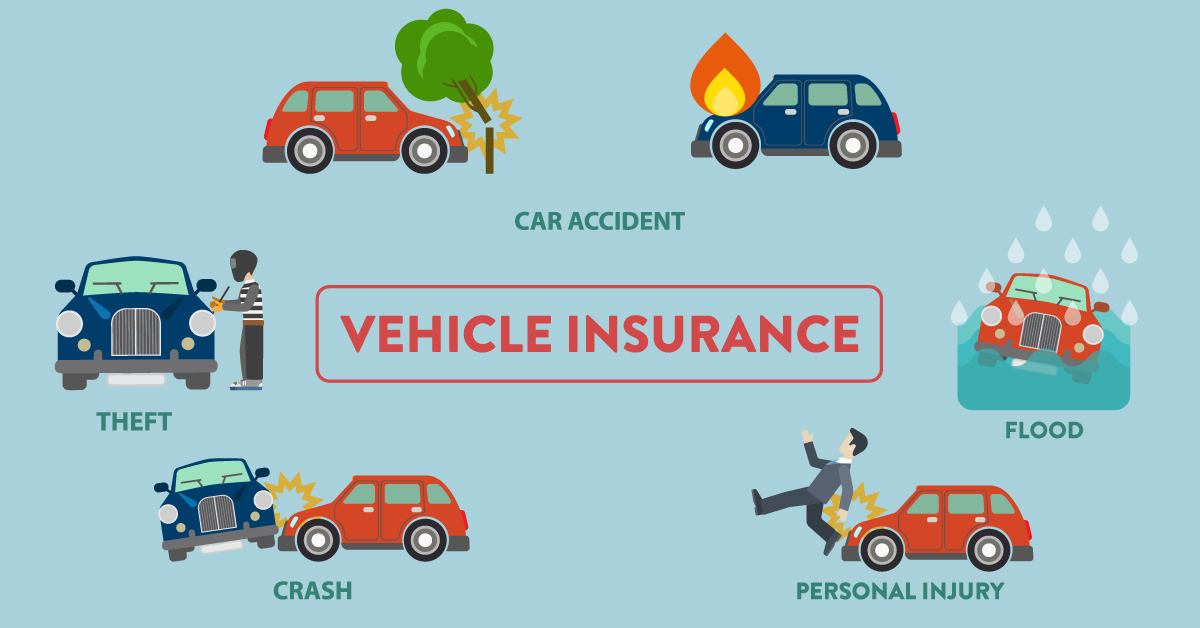

<font size="+3" color='#053c96'><b> Problem Statement</b></font>

Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

<font size="+3" color='#053c96'><b>Bussiness Goal</b></font>

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

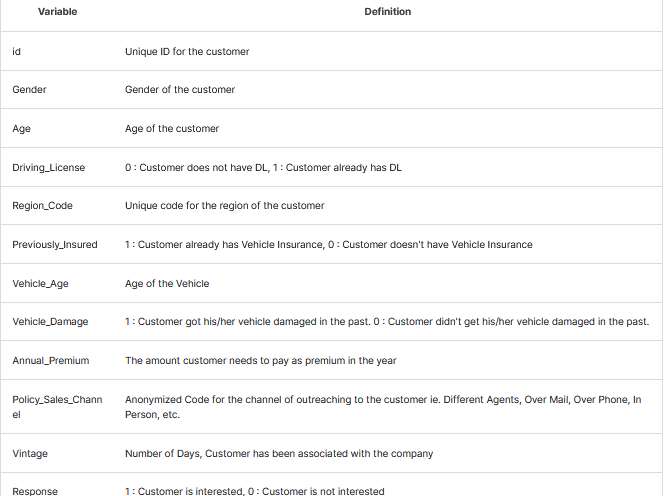

# Importing libraries, functions and loading data

## Imports

In [3]:
import pandas  as pd
import numpy   as np

import matplotlib.pyplot as plt
import seaborn           as sns

from matplotlib.ticker import FuncFormatter

import statsmodels.api as sm
from   statsmodels.stats.proportion import proportions_ztest
from   scipy.stats                  import chisquare, kstest, ttest_ind, kruskal

import scikitplot      as skplt

from sklearn                      import model_selection                as ms
from sklearn.preprocessing        import MinMaxScaler

from sklearn.tree                 import DecisionTreeClassifier
from sklearn.neighbors            import KNeighborsClassifier
from sklearn.linear_model         import LogisticRegression
from sklearn.ensemble             import RandomForestClassifier

from sklearn.metrics              import classification_report

## Define functions

In [4]:
def jupyter_settings():
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    plt.style.use('tableau-colorblind10')

In [5]:
jupyter_settings()

## Load data

In [6]:
# Carregando dados
df_test = pd.read_csv('test.csv', decimal='.', sep=',')

df_train = pd.read_csv('train.csv', decimal='.', sep=',')

# Setting data types

In [7]:
df1 = df_train.copy()

df1 = df1.astype({'Region_Code':'int64',
                  'Policy_Sales_Channel':'int64',
                  'Annual_Premium':'int64'})
df1 = df1.astype({'Region_Code':'category',
                  'Policy_Sales_Channel':'category',
                  'Vehicle_Age':'category',
                  'Previously_Insured':'category',
                  'Driving_License':'category',
                  'Gender':'category',
                  'Vehicle_Damage':'category'})

df1['Gender']               = df1['Gender'].cat.reorder_categories(['Female','Male'], ordered=True)
df1['Driving_License']      = df1['Driving_License'].cat.reorder_categories([0,1], ordered=True)
df1['Region_Code']          = df1['Region_Code'].cat.reorder_categories(np.sort(df1['Region_Code'].unique()), ordered=True)
df1['Previously_Insured']   = df1['Previously_Insured'].cat.reorder_categories([0,1], ordered=True)
df1['Vehicle_Age']          = df1['Vehicle_Age'].cat.reorder_categories(['< 1 Year', '1-2 Year', '> 2 Years'], ordered=True)
df1['Policy_Sales_Channel'] = df1['Policy_Sales_Channel'].cat.reorder_categories(np.sort(df1['Policy_Sales_Channel'].unique()), ordered=True)

# Menos que 5% do dataset de treino apresenta valores da coluna acima de 80000 e para otimizar modelo, valores nessa condicao serao reduzidos para 70000
df1['Annual_Premium']       = np.where(df1['Annual_Premium'] > 80000, 80000, df1['Annual_Premium'])

# Data Description

In [8]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## Data types

In [9]:
df1.dtypes

id                         int64
Gender                  category
Age                        int64
Driving_License         category
Region_Code             category
Previously_Insured      category
Vehicle_Age             category
Vehicle_Damage          category
Annual_Premium             int64
Policy_Sales_Channel    category
Vintage                    int64
Response                   int64
dtype: object

In [10]:
num_cols = df1.select_dtypes(include=['int64','float64']).columns
cat_cols = df1.select_dtypes(exclude=['int64','float64']).columns

## Data distribution

In [11]:
df1.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

### Numerical data

In [12]:
aux = []
for i in num_cols:
    aux.append(len(df1[i].unique()))

aux1 = df1[num_cols].describe().T
aux1['unique'] = aux

aux1

,count,mean,std,min,25%,50%,75%,max,unique
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0,381109
Age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,66
Annual_Premium,381109.0,30394.382995,16076.203974,2630.0,24405.0,31669.0,39400.0,80000.0,46874
Vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,290
Response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,2


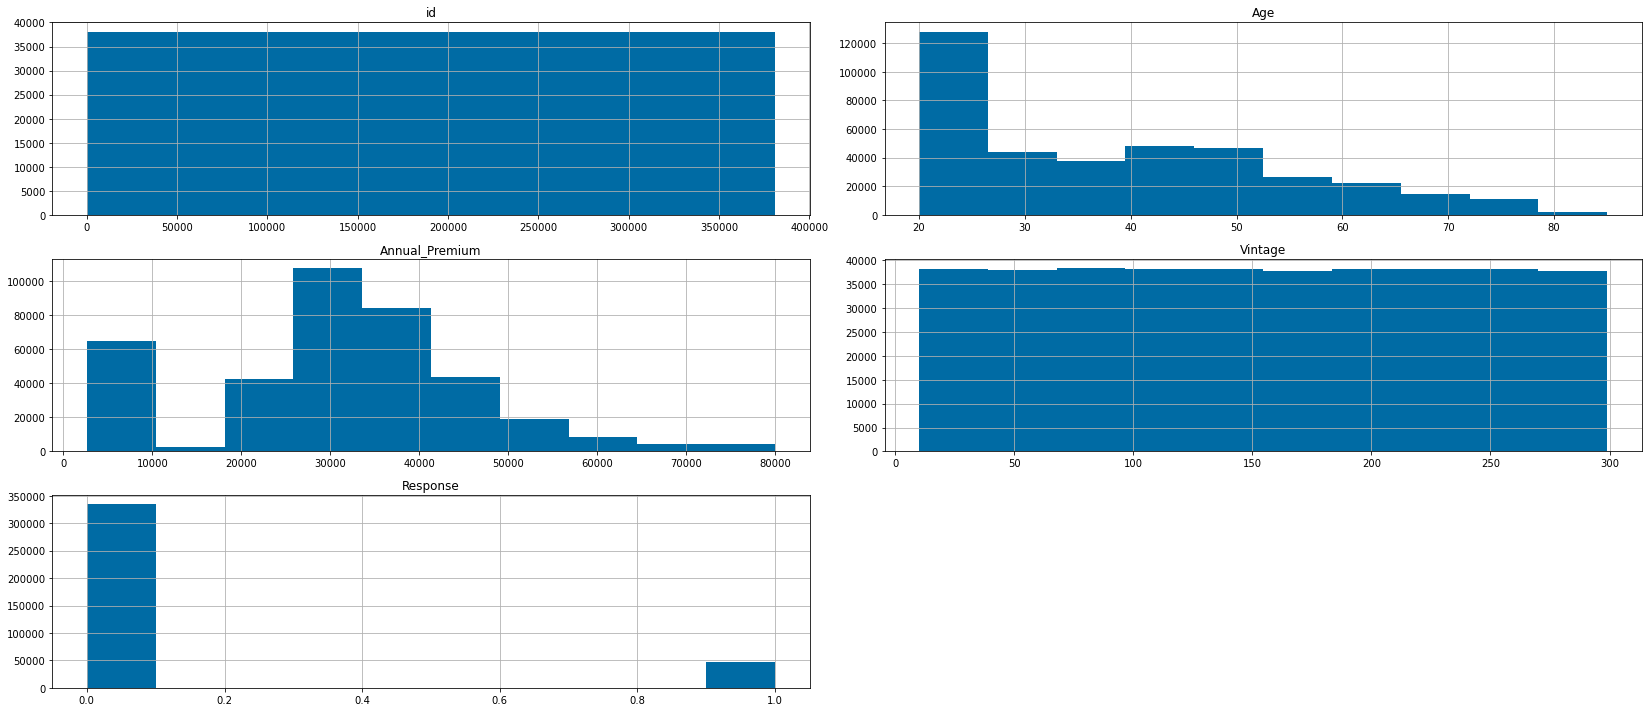

In [13]:
df1[num_cols].hist(figsize=(23,10));

plt.tight_layout()

### Categorical data

In [14]:
df1[cat_cols].describe().T

,count,unique,top,freq
Gender,381109,2,Male,206089
Driving_License,381109,2,1,380297
Region_Code,381109,53,28,106415
Previously_Insured,381109,2,0,206481
Vehicle_Age,381109,3,1-2 Year,200316
Vehicle_Damage,381109,2,Yes,192413
Policy_Sales_Channel,381109,155,152,134784


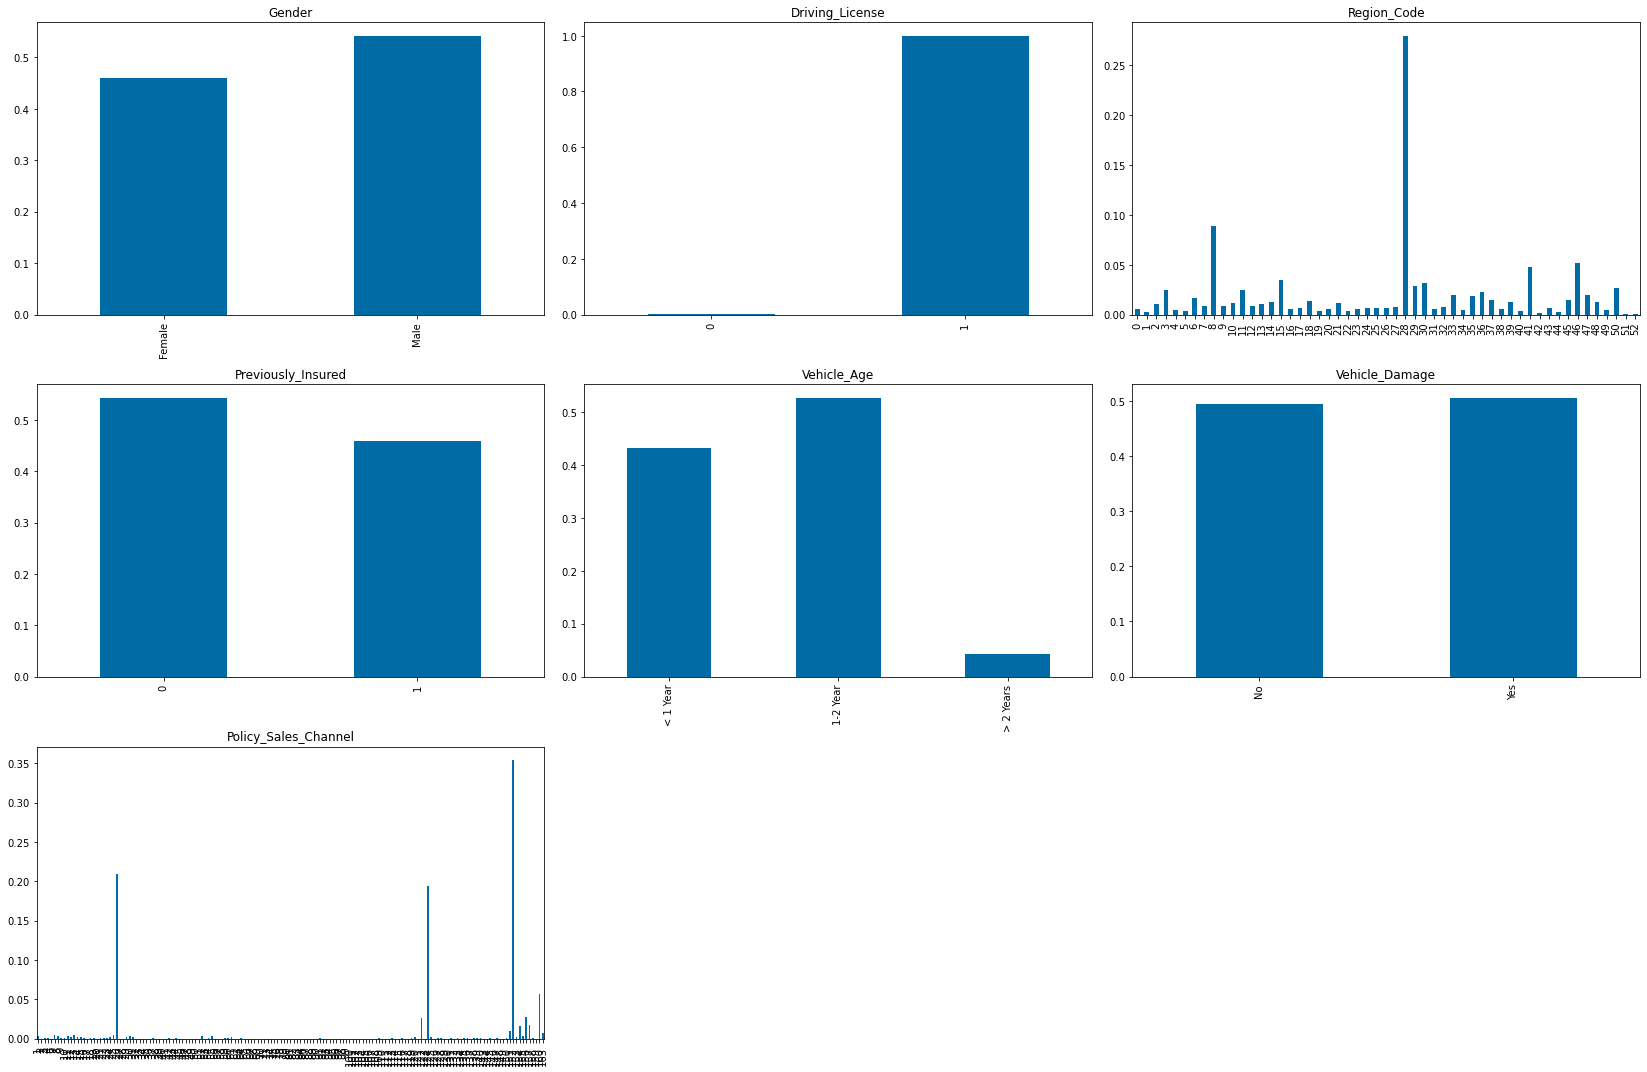

In [15]:
aux = 0
plt.figure(figsize=(23,15))
for ax in np.arange(1,8,1):
    plt.subplot(3,3,ax)
    df1[cat_cols[aux]].value_counts(normalize=True, sort=False).plot(kind='bar')
    plt.title(cat_cols[aux])
    aux += 1
    
plt.tight_layout()

# Exploratory Data Analysis 

In [ ]:
df2 = df1.copy()

df2.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454,26,217,1
1,2,Male,76,1,3,0,1-2 Year,No,33536,26,183,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294,26,27,1


## Policy_Sales_Channel

**Variável relevante, visto que as canais de comunicação possuem intervalos de confiância (IC95) diferentes para a média de retornos positivos**

**Porém há a possibilidade de prejudicar o modelo a depdender do Enconding, pois existem muitos canais de comunicação**

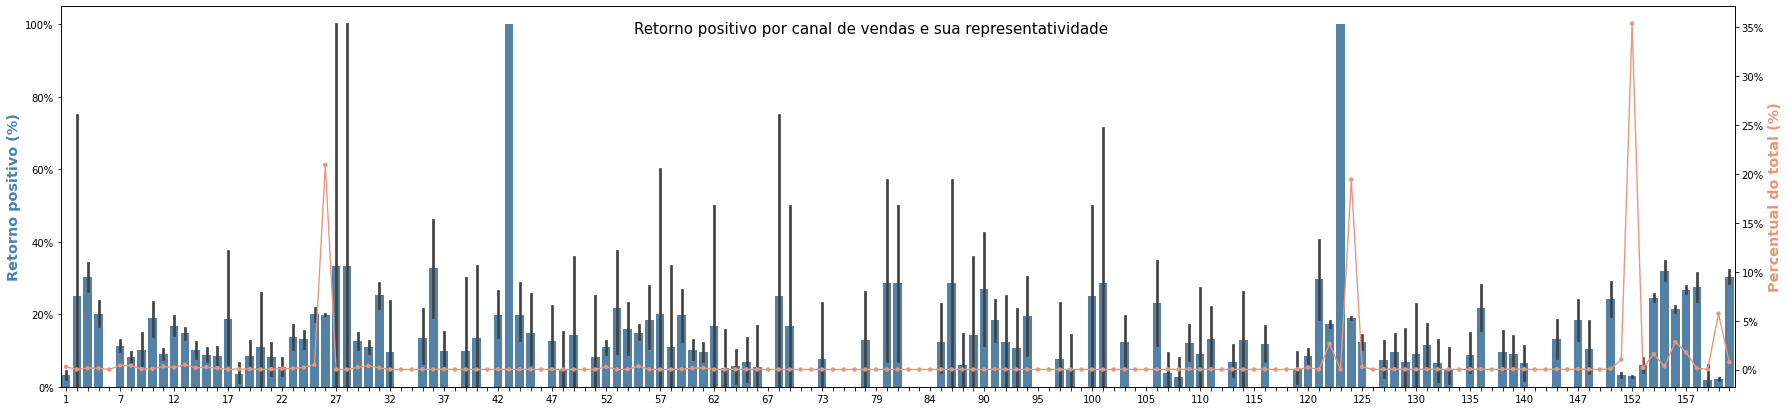

In [ ]:
aux = df2.value_counts('Policy_Sales_Channel', normalize=True)

fig, ax = plt.subplots(figsize=(30,7))
ax2 = ax.twinx()

sns.barplot(data=df2,
            x='Policy_Sales_Channel',
            y='Response',
            color='steelblue',
            ax=ax)

sns.pointplot(x=aux.index,
              y=aux.values,
              color='darksalmon',
              scale=0.5,
              ax=ax2)

# Oculta valores do eixo x
[j.set_visible(False) for (i,j) in enumerate(ax.xaxis.get_ticklabels()) if i % 5 != 0]

ax.set_xlabel('')

ax.set_ylabel('Retorno positivo (%)', fontsize='x-large', fontweight='semibold', color='steelblue');
ax2.set_ylabel('Percentual do total (%)', fontsize='x-large', fontweight='semibold', color='darksalmon');

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

fig.suptitle(t='Retorno positivo por canal de vendas e sua representatividade', y=0.85, fontsize=15);

**Considerando somente canais com mais de 30 ligações, como o interesse decai em relação a cada canal?**

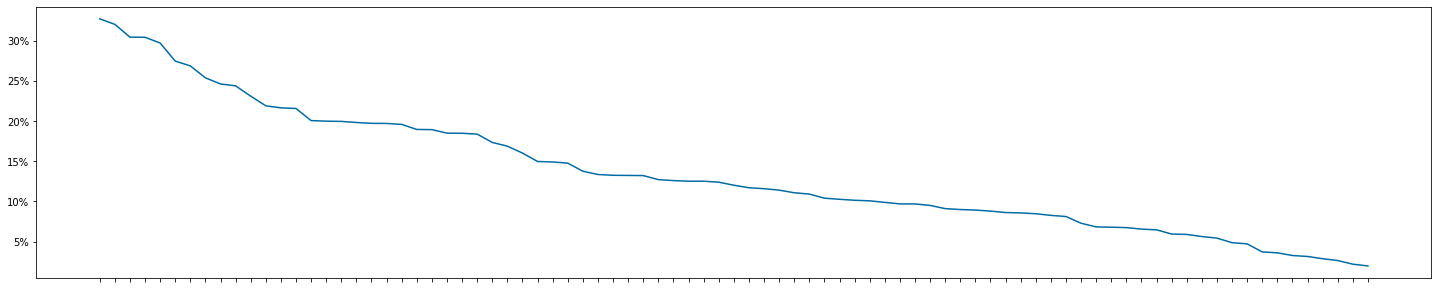

In [ ]:
aux = (df2.groupby('Policy_Sales_Channel')
         ['Response']
         .agg(media_interesse='mean', 
              contatos_efetuados='count')
         .query('contatos_efetuados > 30')    
         .sort_values(by='media_interesse',
                      ascending=False)
         .reset_index())

fig, ax = plt.subplots(figsize=(25,5))
plt.plot(aux.index, aux['media_interesse']);
plt.xticks(ticks=np.arange(0,len(aux),1), labels='');

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

## Gender

**Há evidencias estatisticas que homens tendem a aceitar mais o seguro**

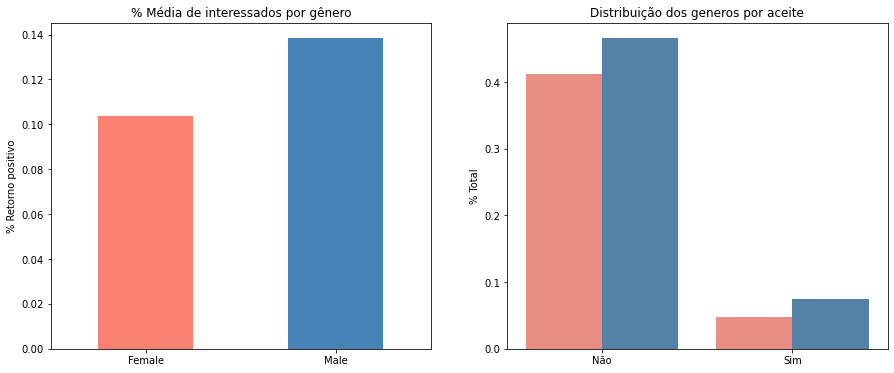

In [ ]:
aux = (pd.DataFrame(
        df2.value_counts(['Response','Gender'], normalize=True))
        .reset_index()
        .rename(columns={0:'perc'}))

plt.figure(figsize=(15,6))

# Primeiro grafico
plt.subplot(1,2,1)
plt.title('% Média de interessados por gênero')
(df2.groupby('Gender')
    ['Response']
    .mean()
    .plot(kind='bar', color=['salmon','steelblue']));

plt.xlabel('')
plt.xticks(rotation=0)
plt.ylabel('% Retorno positivo')

# Segundo grafico
plt.subplot(1,2,2)
plt.title('Distribuição dos generos por aceite')
sns.barplot(data=aux,
              x='Response',
              y='perc',
              hue='Gender',
              hue_order=['Female','Male'],
              palette=['salmon','steelblue'],
              )

plt.xticks(ticks= [0,1], labels=['Não','Sim']);
plt.xlabel('');
plt.ylabel('% Total')
plt.legend('',frameon=False);

Teste de proporção Z-test

"This uses a simple normal test for proportions. It should be the same as running the mean z-test on the data encoded 1 for event and 0 for no event so that the sum corresponds to the count."

Ref: https://www.statsmodels.org/devel/generated/statsmodels.stats.proportion.proportions_ztest.html

In [ ]:
count = [df2.groupby('Gender')['Response'].sum()['Female'], 
         df2.groupby('Gender')['Response'].sum()['Male']]

nobs = [df2.groupby('Gender')['Response'].count()['Female'], 
         df2.groupby('Gender')['Response'].count()['Male']]

stat, pval = proportions_ztest(count, nobs)

display(pval)

6.528551393737617e-230

## Age

**Sim, há evidências estatísticas de que pessoas mais velhas tendem a aceitar mais o seguro**

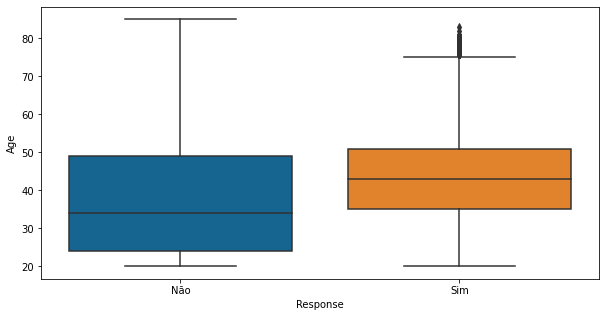

In [ ]:
plt.figure(figsize=(10, 5))

sns.boxplot(data=df2,
            x='Response',
            y='Age');

plt.xticks([0,1], ['Não', 'Sim']);

**Os dados das duas distribuições são normais?**

**Não. Avaliando estatísticamente ambas distribuições são não-Gaussianas.**

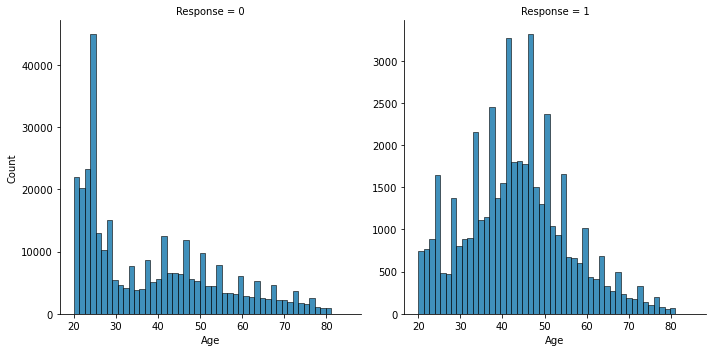

In [ ]:
sns.displot(data=df2,
             x='Age',
             col='Response',
             kind='hist',
             bins=50,
             facet_kws=dict(sharey=False));

Teste de Kolmogorov-Smirnov para normalidade dos dados

"Performs the (one-sample or two-sample) Kolmogorov-Smirnov test for goodness of fit." 

"The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical."

Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

In [ ]:
print('Para os que não aceitaram o plano:')
display(kstest(df2[df2['Response'] == 0]['Age'], 'norm'))

print('')

print('Para os que aceitaram o plano:')
display(kstest(df2[df2['Response'] == 1]['Age'], 'norm'))

print('\nVisto que ambos p-valores são < 0.05, rejeitamos a hipótese nula da normalidade \n')

Para os que não aceitaram o plano:


KstestResult(statistic=1.0, pvalue=0.0)


Para os que aceitaram o plano:


KstestResult(statistic=1.0, pvalue=0.0)


Visto que ambos p-valores são < 0.05, rejeitamos a hipótese nula da normalidade 



In [ ]:
#H0 -> As médias das duas distribuições é a mesma

ttest_ind(df2[df2['Response'] == 0]['Age'],
          df2[df2['Response'] == 1]['Age'])

Ttest_indResult(statistic=-69.04306475777734, pvalue=0.0)

**Rejeitamos H0**




## Vehicle_Age

In [ ]:
pd.pivot_table(data=df2,
               index='Response',
               columns='Vehicle_Age',
               values='id',
               aggfunc='count').apply(lambda x: x / x.sum(), axis=0)

Vehicle_Age,< 1 Year,1-2 Year,> 2 Years
Response,,,
0,0.956295,0.826245,0.706254
1,0.043705,0.173755,0.293746


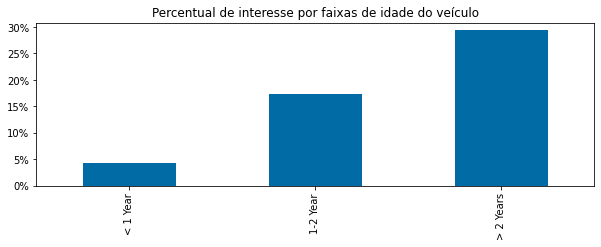

In [ ]:
fig, ax = plt.subplots(figsize=(10,3))

df2.groupby('Vehicle_Age')['Response'].mean().plot(kind='bar')
plt.title('Percentual de interesse por faixas de idade do veículo')
plt.xlabel('')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

**Podemos usar o teste ANOVA para validar se há diferença entre distribuicoes?**

"The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

    The samples are independent. - OK

    Each sample is from a normally distributed population. - DEVIDO AO VOLUME DE DADOS PODEMOS ASSUMIR QUE SIM

    The population standard deviations of the groups are all equal. This property is known as homoscedasticity. - DESVIOS PADRÕES SÃO DIFERENTES (SNIPPET ABAIXO)"
    
Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html

In [ ]:
df2.groupby('Vehicle_Age')['Response'].std()

Vehicle_Age
< 1 Year     0.204439
1-2 Year     0.378900
> 2 Years    0.455491
Name: Response, dtype: float64

**Dessa forma, seguiremos com o Kruskal-Wallis H-test**

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes. Note that rejecting the null hypothesis does not indicate which of the groups differs. Post hoc comparisons between groups are required to determine which groups are different.

Souce: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal

In [ ]:
kruskal(df2[df2['Vehicle_Age'] == '< 1 Year']['Response'],
        df2[df2['Vehicle_Age'] == '1-2 Year']['Response'],
        df2[df2['Vehicle_Age'] == '> 2 Years']['Response'])

KruskalResult(statistic=18771.840648190908, pvalue=0.0)

## Region_Code

**Sim, visto que as regiões possuem intervalos de confiância (IC95) diferentes para a média de retornos positivos**

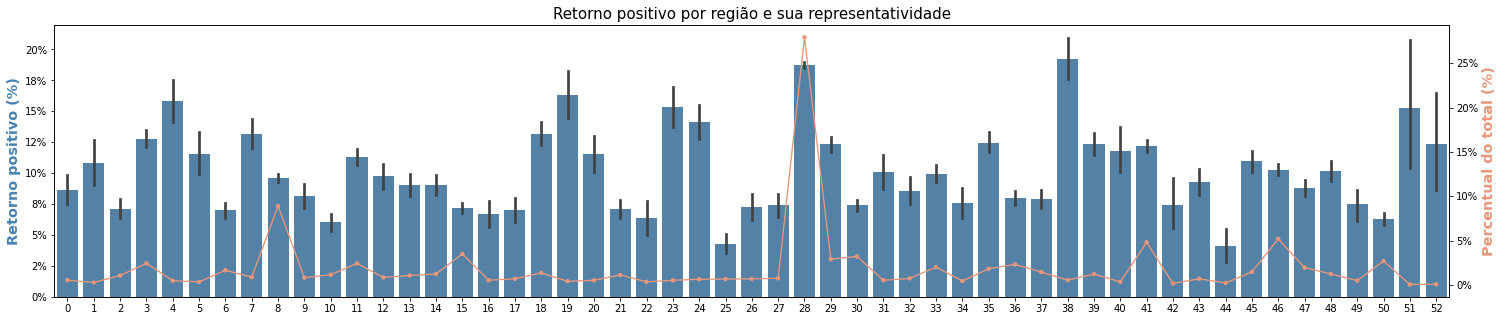

In [ ]:
aux = df2.value_counts('Region_Code', normalize=True)

fig, ax = plt.subplots(figsize=(25,5))
ax2 = ax.twinx()

sns.barplot(data=df2,
            x='Region_Code',
            y='Response',
            color='steelblue',
            ax=ax)

sns.pointplot(x=aux.index,
              y=aux.values,
              color='darksalmon',
              scale=0.5,
              ax=ax2)

ax.set_ylabel('Retorno positivo (%)', fontsize='x-large', fontweight='semibold', color='steelblue');
ax2.set_ylabel('Percentual do total (%)', fontsize='x-large', fontweight='semibold', color='darksalmon');

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

ax.set_xlabel('')
plt.title(label='Retorno positivo por região e sua representatividade', fontsize=15);

## Vintage

**A variável é pouco relevante para distinguir o aceite dos clientes**

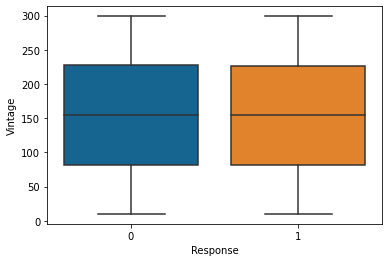

In [ ]:
sns.boxplot(data=df2,
            y='Vintage',
            x='Response');

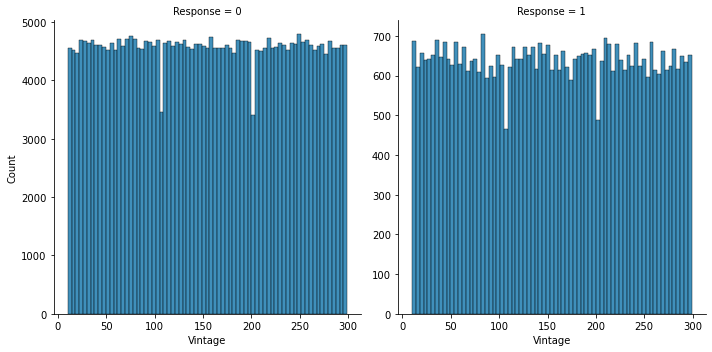

In [ ]:
sns.displot(data=df2,
            kind='hist',
            x='Vintage',
            col='Response',
            facet_kws=dict(sharey=False));

## Annual_Premium

**A variável é pouco relevante para distinguir o aceite dos clientes**

(0.0, 80000.0)

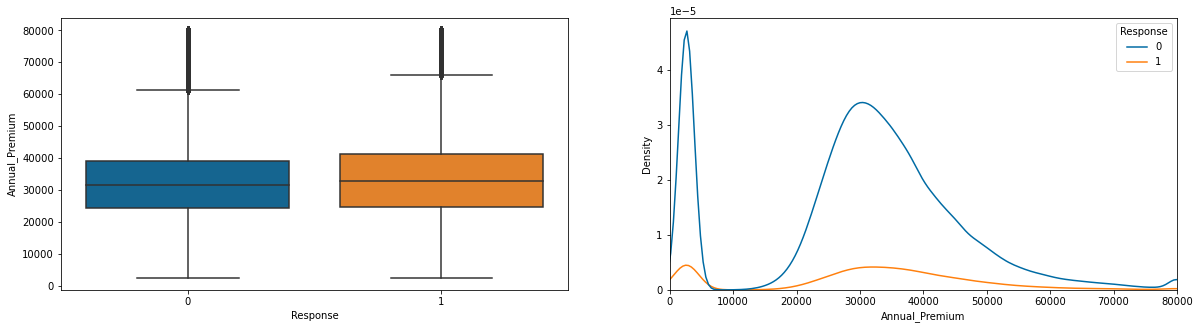

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.boxplot(data=df2,
            y='Annual_Premium',
            x='Response');

plt.subplot(1,2,2)
sns.kdeplot(data=df2,
            x='Annual_Premium',
            hue='Response');

plt.xlim([0,80000])

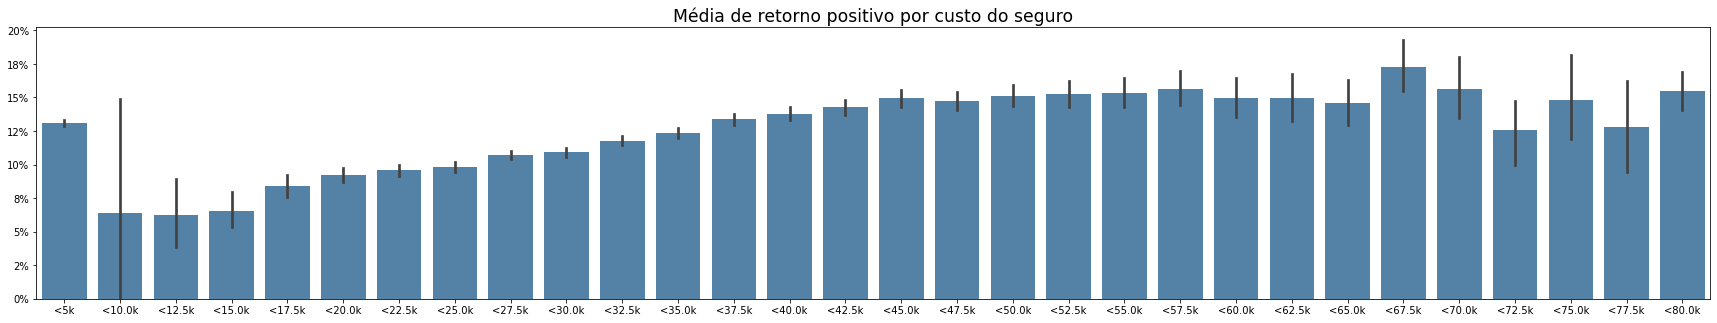

In [ ]:
# Cria array e insere valor 0 no inicio
aux = np.insert(np.arange(10000,85000,2500), 0, 0)

fig, ax = plt.subplots(figsize=(30,5))

sns.barplot(data=None,
              x=pd.cut(x=df2['Annual_Premium'],
                        bins=aux,
                        labels=(['<5k'] + list(['<' + str(x/1000) + 'k' for x in aux])[1:-1]),
                        right=False,
                        include_lowest=True ),
              y=df2['Response'],
              color='steelblue');

plt.title('Média de retorno positivo por custo do seguro', fontsize='xx-large')
ax.set_ylabel('')
ax.set_xlabel('')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

## Driving_License

**Sim! Pessoas com habilitação tendem a aceitar com mais frequência o seguro**

In [ ]:
(df2.groupby('Driving_License')
    ['Response']
    .agg(qtd_respostas_positivas='sum',
         porcentagem_positiva='mean')
    .round(2)).T

Driving_License,0,1
qtd_respostas_positivas,41.00,46669.00
porcentagem_positiva,0.05,0.12


Teste de proporção Z-test

"This uses a simple normal test for proportions. It should be the same as running the mean z-test on the data encoded 1 for event and 0 for no event so that the sum corresponds to the count."

Ref: https://www.statsmodels.org/devel/generated/statsmodels.stats.proportion.proportions_ztest.html

In [ ]:
count = [df2.groupby('Driving_License')['Response'].sum()[0], 
         df2.groupby('Driving_License')['Response'].sum()[1]]

nobs = [df2.groupby('Driving_License')['Response'].count()[0], 
         df2.groupby('Driving_License')['Response'].count()[1]]

stat, pval = proportions_ztest(count, nobs)

display(pval)

3.6291206482032876e-10

## Vehicle_Damage

**Sim! Pessoas que já bateram o carro tendem a aceitar mais o seguro** 

In [ ]:
(df2.groupby('Vehicle_Damage')
    ['Response']
    .agg(representatividade_total='count',
         qtd_respostas_positivas='sum',
         porcentagem_positiva='mean')
    .round(2)).T

Vehicle_Damage,No,Yes
representatividade_total,188696.00,192413.00
qtd_respostas_positivas,982.00,45728.00
porcentagem_positiva,0.01,0.24


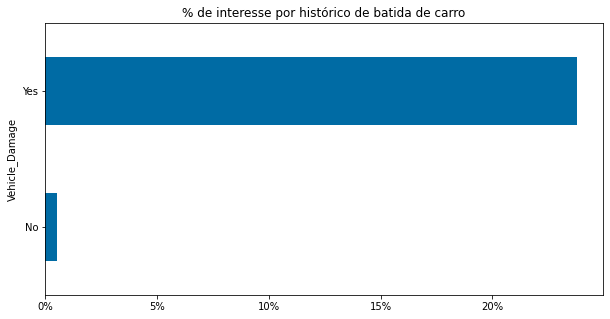

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

(df2.groupby('Vehicle_Damage')
    ['Response']
    .mean()).plot(kind='barh');

plt.title('% de interesse por histórico de batida de carro')
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

## Previously_Insured

**Sim, pessoas não asseguradas tendem a aceitar mais o novo seguro**

In [ ]:
(df2.groupby('Previously_Insured')
    ['Response']
    .agg(representatividade_total='count',
         qtd_respostas_positivas='sum',
         porcentagem_positiva='mean')
    .round(2)).T

Previously_Insured,0,1
representatividade_total,206481.00,174628.0
qtd_respostas_positivas,46552.00,158.0
porcentagem_positiva,0.23,0.0


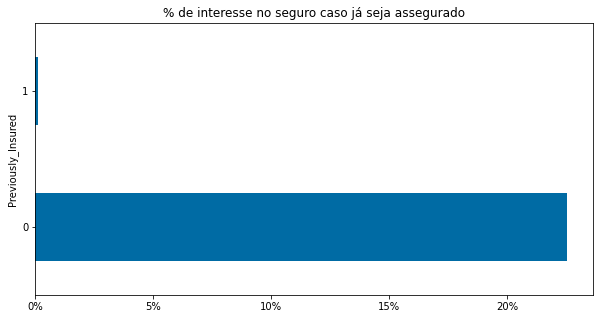

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

(df2.groupby('Previously_Insured')
    ['Response']
    .mean()).plot(kind='barh');

plt.title('% de interesse no seguro caso já seja assegurado')
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

## EDA Summary

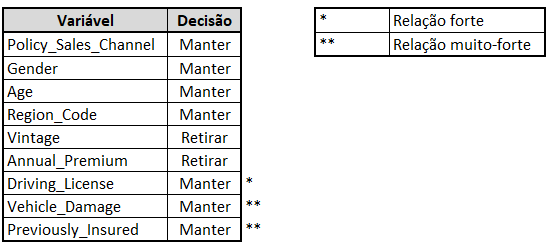

# Preparing data for model

## Splitting

In [ ]:
df3 = df2.copy()

df3_y = df3[['Response']]
df3_x = df3.drop(columns=['id','Vintage','Annual_Premium','Response'])

x_train, x_val, y_train, y_val = ms.train_test_split(df3_x, df3_y, test_size=0.2, random_state=42)

## Train data

In [ ]:
df4 = pd.concat( [x_train, y_train], axis=1 )

# Target encoding POLICY_SALES_CHANNEL, REGION_CODE
target_encoding_policy_sales_channel = (df4.groupby('Policy_Sales_Channel')
                                        ['Response'].mean()
                                        .to_dict())
df4['Policy_Sales_Channel'] = df4['Policy_Sales_Channel'].map(target_encoding_policy_sales_channel)

target_encoding_region_code = (df3.groupby('Region_Code')
                                ['Response'].mean()
                                .to_dict())
df4['Region_Code'] = df4['Region_Code'].map(target_encoding_region_code)

# One hot encoding - GENDER, DRIVING_LICENSE, VEHICLE_DAMAGE, PREVIOSLY_INSURED
df4 = pd.get_dummies(df4, columns=['Gender'], prefix='Gender')
df4 = pd.get_dummies(df4, columns=['Driving_License'], prefix='Driving_License')

# Label Encoding - VEHICLE_DAMAGE, PREVIOUSLY_INSURED
df4['Vehicle_Damage']       = df4['Vehicle_Damage'].cat.rename_categories({'No':0, 'Yes':1})
df4['Previously_Insured']   = df4['Previously_Insured'].cat.rename_categories({0:1, 1:0})
df4['Vehicle_Age']          = df4['Vehicle_Age'].cat.rename_categories({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2})

# Min Max Scaler - AGE
min_max_scaler_age = MinMaxScaler()
df4['Age'] = min_max_scaler_age.fit_transform(np.array(df4[['Age']]))

y_train = df4[['Response']].values
x_train = df4.drop(columns=['Response'])

## Validation data

In [ ]:
# Target encoding POLICY_SALES_CHANNEL, REGION_CODE
x_val['Policy_Sales_Channel'] = x_val['Policy_Sales_Channel'].map(target_encoding_policy_sales_channel)
x_val['Region_Code'] = x_val['Region_Code'].map(target_encoding_region_code)

# One hot encoding - GENDER, DRIVING_LICENSE, VEHICLE_DAMAGE, PREVIOSLY_INSURED
x_val = pd.get_dummies(x_val, columns=['Gender'], prefix='Gender')
x_val = pd.get_dummies(x_val, columns=['Driving_License'], prefix='Driving_License')

# Label Encoding - VEHICLE_DAMAGE, PREVIOUSLY_INSURED
x_val['Vehicle_Damage']       = x_val['Vehicle_Damage'].cat.rename_categories({'No':0, 'Yes':1})
x_val['Previously_Insured']   = x_val['Previously_Insured'].cat.rename_categories({0:1, 1:0})
x_val['Vehicle_Age']          = x_val['Vehicle_Age'].cat.rename_categories({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2})

# Min Max Scaler - AGE
x_val['Age'] = min_max_scaler_age.transform(np.array(x_val[['Age']]))

# Fillna para campos que não foi achado correspondencia
x_val = x_val.fillna(0)

C:\Users\joaov\AppData\Local\Temp/ipykernel_13660/851128030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['Policy_Sales_Channel'] = x_val['Policy_Sales_Channel'].map(target_encoding_policy_sales_channel)
C:\Users\joaov\AppData\Local\Temp/ipykernel_13660/851128030.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['Region_Code'] = x_val['Region_Code'].map(target_encoding_region_code)


# Fitting model

In [ ]:
def ranking_metrics( model, x_train, y_train, y_val, k=100 ):
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_val)
        
    aux = y_val
    aux['score'] = y_pred[:, 1].tolist()
    aux = aux.sort_values('score', ascending= False)

    aux = aux.reset_index(drop=True)
    aux['ranking'] = aux.index + 1
    aux['precision_at_k'] = aux['Response'].cumsum() / aux['ranking']
    aux['recall_at_k']    = aux['Response'].cumsum() / aux['Response'].sum()
    
    print('A precisao ate a posicao {} foi de: {:.1f}'.format(k, aux.loc[ k, 'precision_at_k']))
    print('O recall ate a posicao {} foi de: {:.1f}'.format(k, aux.loc[ k, 'recall_at_k']))
    
    plt.figure(figsize=(15,5))
    plt.plot(aux['ranking'], aux['precision_at_k'], label='precision_at_k')
    plt.plot(aux['ranking'], aux['recall_at_k'], label='recall_at_k')
    plt.legend(loc='upper right', fontsize=10)
    plt.xlim([-500,10000])
      
    return( aux.loc[ k, 'precision_at_k'], aux.loc[ k, 'recall_at_k'])   

## Decision Tree

In [ ]:
mdl_tree = DecisionTreeClassifier()

mdl_tree.fit(x_train, y_train)

y_pred_tree = mdl_tree.predict_proba(x_val)

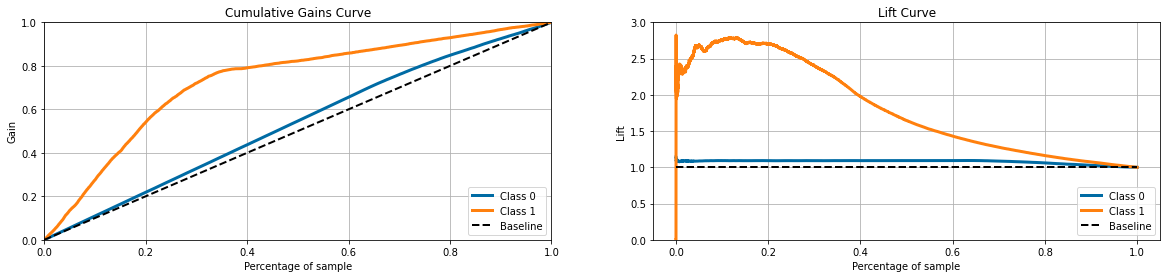

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,4))

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, y_pred_tree, ax=ax[0] );
skplt.metrics.plot_lift_curve( y_val, y_pred_tree, ax=ax[1] );
ax[1].set_ylim([0,3]);

## KNN

In [ ]:
mdl_knn = KNeighborsClassifier( n_neighbors=4, n_jobs=-1)

mdl_knn.fit(x_train, np.ravel(y_train))

y_pred_knn = mdl_knn.predict_proba(x_val)

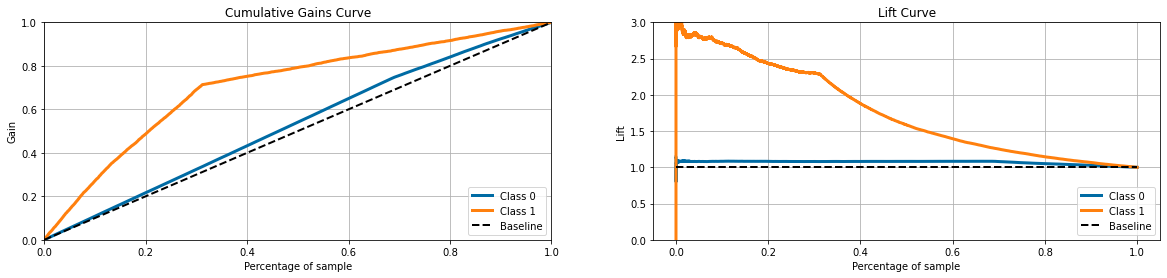

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,4))

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, y_pred_knn, ax=ax[0] );
skplt.metrics.plot_lift_curve( y_val, y_pred_knn, ax=ax[1] );
ax[1].set_ylim([0,3]);

## Logistic Regression

In [ ]:
mdl_logreg = LogisticRegression(max_iter=80, n_jobs=-1)

mdl_logreg.fit(x_train, np.ravel(y_train))

y_pred_logreg = mdl_logreg.predict_proba(x_val)

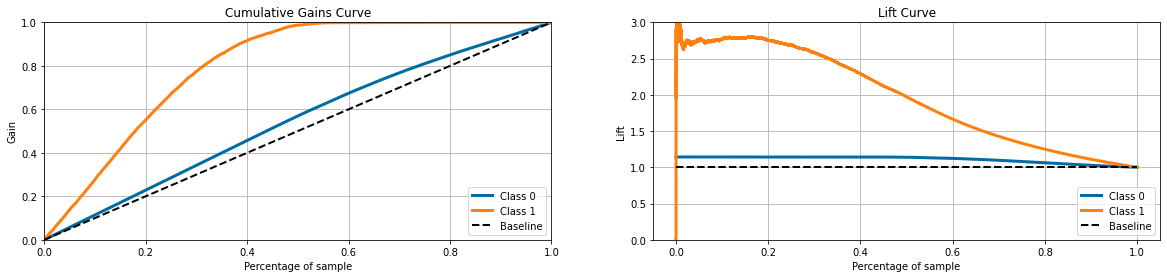

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,4))

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, y_pred_logreg, ax=ax[0] );
skplt.metrics.plot_lift_curve( y_val, y_pred_logreg, ax=ax[1] );
ax[1].set_ylim([0,3]);

## Random Forest

In [ ]:
mdl_rf = RandomForestClassifier()

mdl_rf.fit(x_train, np.ravel(y_train))
y_pred_rf = mdl_rf.predict_proba(x_val)

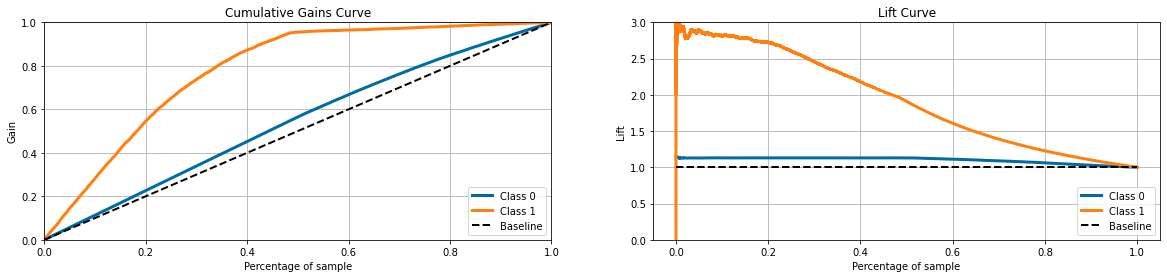

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,4))

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, y_pred_rf, ax=ax[0] );
skplt.metrics.plot_lift_curve( y_val, y_pred_rf, ax=ax[1]);
ax[1].set_ylim([0,3]);